# Usando ML para modelar os dados

> Jean Cardoso, Ph.D.

## Instalando e carregando pacotes

In [60]:
# Carregando o notebook externo
!pip install -q import-ipynb
!pip install -q boruta
!pip install -q mrmr-selection
!pip install -q optuna
!pip install -q tensorflow

In [96]:
import import_ipynb

#from google.colab import drive
#drive.mount('/content/drive')

# Caminho para o notebook `features.ipynb` no Google Drive
notebook_path = '/content/drive/MyDrive/case_rentcars/case_rentcars/modeling/train_ML.ipynb'

In [97]:
# Importando as funções do notebook
import nbformat
from nbconvert import PythonExporter

with open(notebook_path) as f:
    nb = nbformat.read(f, as_version=4)

exporter = PythonExporter()
source, _ = exporter.from_notebook_node(nb)
exec(source)

In [91]:
# Importando pacotes
import pandas as pd
import numpy as np
import json
import os
import time
import joblib
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from boruta import BorutaPy
import optuna
from optuna import create_study
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import ks_2samp
import mrmr
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, log_loss, precision_score, recall_score, f1_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Importando dados

In [82]:
# Carregando dados de treino
df = pd.read_parquet('/content/drive/MyDrive/case_rentcars/data/processed/data_train.parquet')
print(df.shape)
df.head()

(1384617, 32)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,user_hour_order_freq,user_dow_order_freq,user_avg_days_since_prior,user_days_since_last_order,product_popularity,user_product_popularity,product_avg_days_since_prior,product_order_freq,product_reorder_ratio,avg_pos_incart
0,1187899,1,train,11,4,8,14.0,196,1,1,...,14,9,18.542374,30.0,35791.0,4.473875,11.195804,35791.0,0.776480,3.721774
1,1187899,1,train,11,4,8,14.0,25133,2,1,...,14,9,18.542374,30.0,6196.0,3.848447,9.564880,6196.0,0.740155,7.001614
2,1187899,1,train,11,4,8,14.0,38928,3,1,...,14,9,18.542374,30.0,13238.0,5.806140,9.666038,13238.0,0.827769,3.487309
3,1187899,1,train,11,4,8,14.0,26405,4,1,...,14,9,18.542374,30.0,1214.0,1.790560,14.831961,1214.0,0.441516,3.116969
4,1187899,1,train,11,4,8,14.0,39657,5,1,...,14,9,18.542374,30.0,5019.0,4.278772,10.549313,5019.0,0.766288,4.081491


In [83]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_train.shape, df_test.shape

((969231, 32), (415386, 32))

In [84]:
df_train['is_test'] = 0
df_test['is_test'] = 1

data_model = pd.concat([df_train, df_test])
data_model.shape

(1384617, 33)

In [85]:
list(data_model.columns)

['order_id',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'user_order_count',
 'user_avg_products_per_order',
 'user_unique_products',
 'user_reorder_ratio',
 'user_avg_days_between_orders',
 'user_reorder_rate',
 'user_reorder_freq',
 'user_reordered_products_ratio',
 'order_dow_sin',
 'order_dow_cos',
 'order_hour_of_day_sin',
 'order_hour_of_day_cos',
 'user_hour_order_freq',
 'user_dow_order_freq',
 'user_avg_days_since_prior',
 'user_days_since_last_order',
 'product_popularity',
 'user_product_popularity',
 'product_avg_days_since_prior',
 'product_order_freq',
 'product_reorder_ratio',
 'avg_pos_incart',
 'is_test']

In [86]:
target = 'reordered'
cols_var = ['user_order_count',
            'user_avg_products_per_order',
            'user_unique_products',
            'user_reorder_ratio',
            'user_avg_days_between_orders',
            'user_reorder_rate',
            'user_reorder_freq',
            'user_reordered_products_ratio',
            'order_dow_sin',
            'order_dow_cos',
            'order_hour_of_day_sin',
            'order_hour_of_day_cos',
            'user_hour_order_freq',
            'user_dow_order_freq',
            'user_avg_days_since_prior',
            'user_days_since_last_order',
            'product_popularity',
            'user_product_popularity',
            'product_avg_days_since_prior',
            'product_order_freq',
            'product_reorder_ratio',
            'avg_pos_incart']
cols_cat = []

## Medelagem ML

In [99]:
# Instanciar o modelo
model_ = SimplifiedLGBMModel(
    data=data_model,
    features=cols_var,
    target=target,
    categorical_features=cols_cat,
    test_flag_label="is_test",
    test_size=0.3,
    random_state=42,
)

100%|██████████| 22/22 [00:05<00:00,  3.79it/s]


Selected features (MRMR): ['user_reorder_ratio', 'product_reorder_ratio', 'user_reorder_rate', 'user_product_popularity', 'user_reordered_products_ratio', 'user_reorder_freq', 'avg_pos_incart', 'user_order_count', 'product_popularity', 'user_avg_products_per_order', 'user_unique_products', 'product_order_freq', 'user_dow_order_freq', 'user_hour_order_freq', 'user_avg_days_between_orders', 'user_avg_days_since_prior', 'user_days_since_last_order', 'product_avg_days_since_prior', 'order_hour_of_day_sin', 'order_dow_sin', 'order_hour_of_day_cos', 'order_dow_cos']
[LightGBM] [Info] Number of positive: 579964, number of negative: 389267
[LightGBM] [Info] Total Bins 4240
[LightGBM] [Info] Number of data points in the train set: 969231, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398701
[LightGBM] [Info] Start training from score 0.398701
Removed constant features: []
Removed correlated features: ['user_reorder_rate', 'user_product_popul

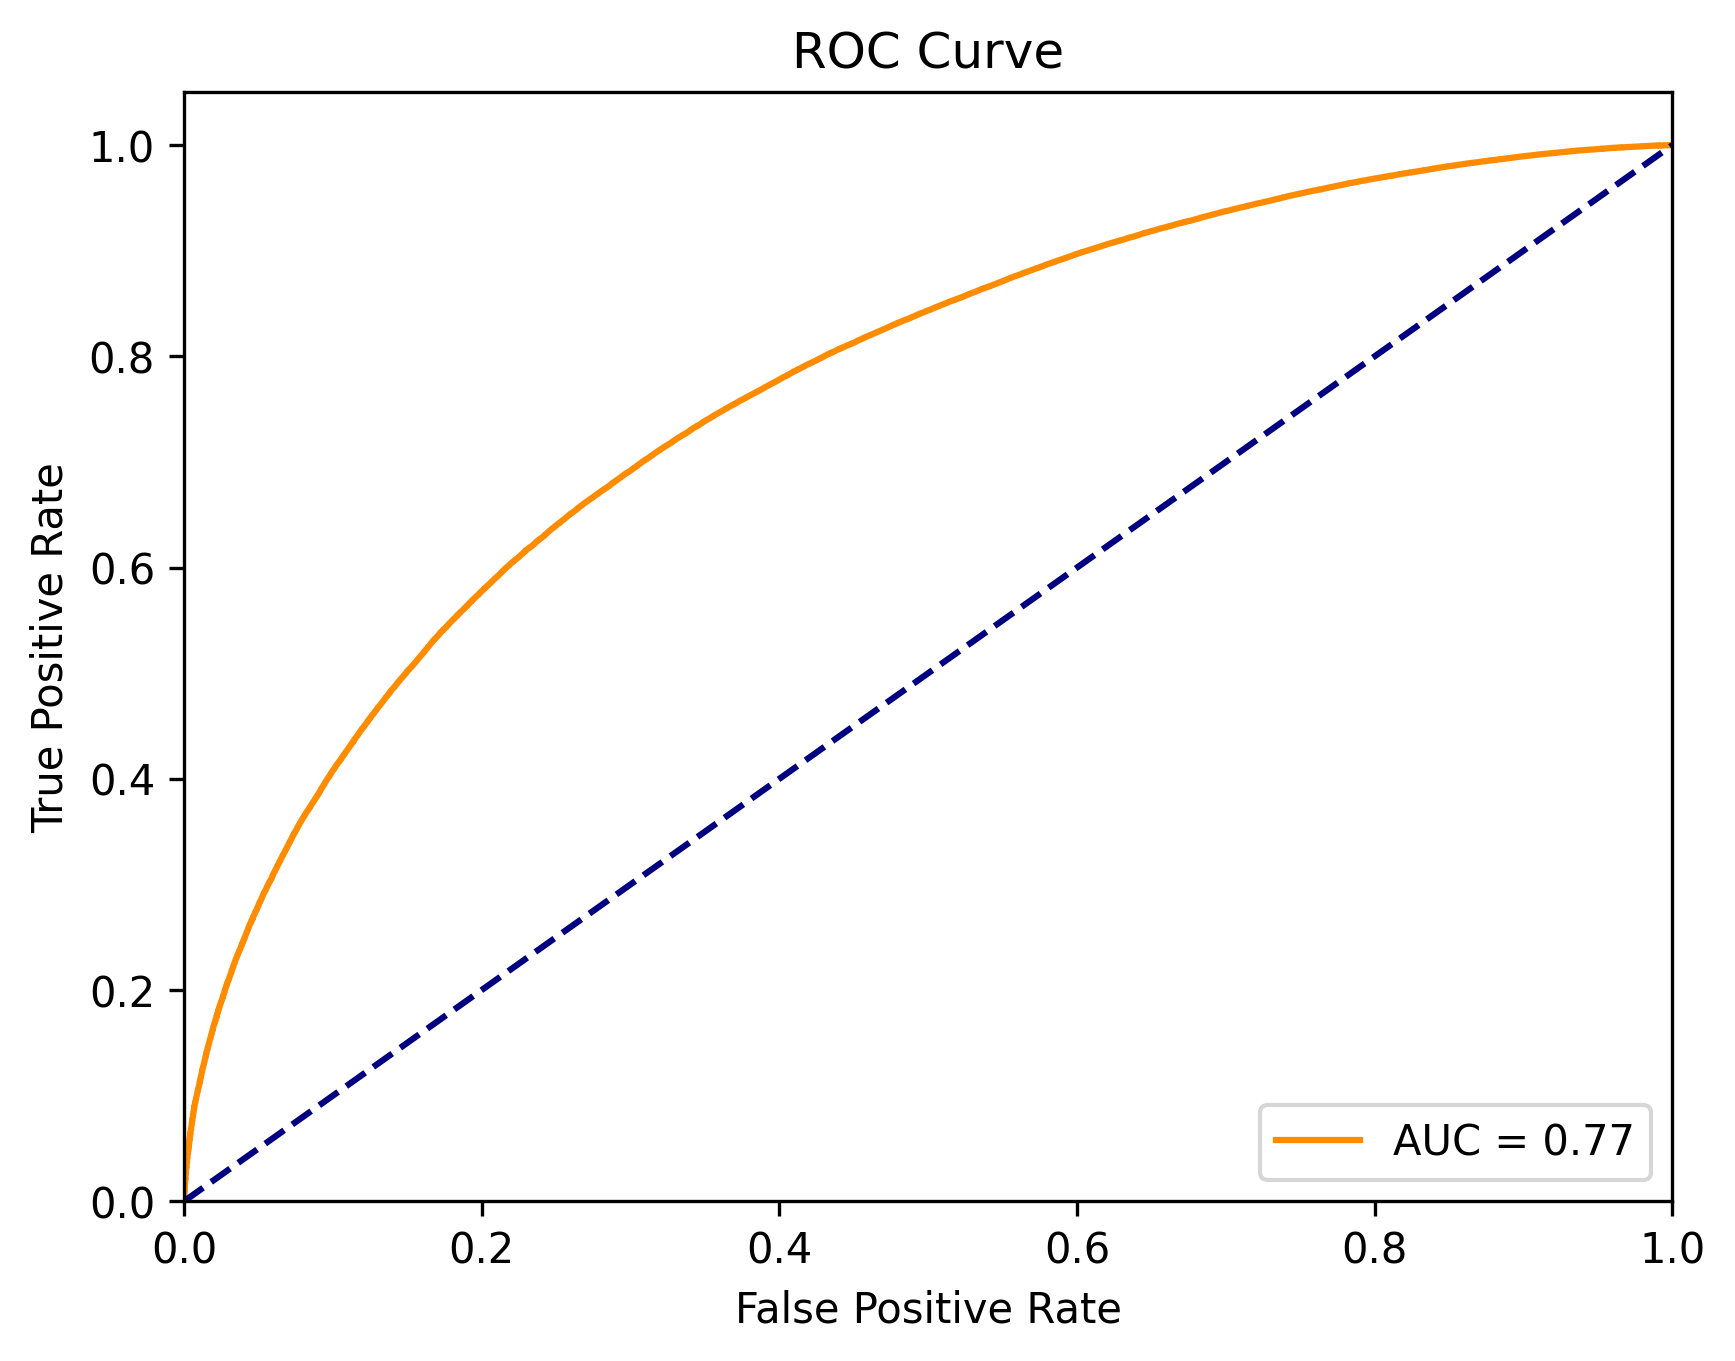

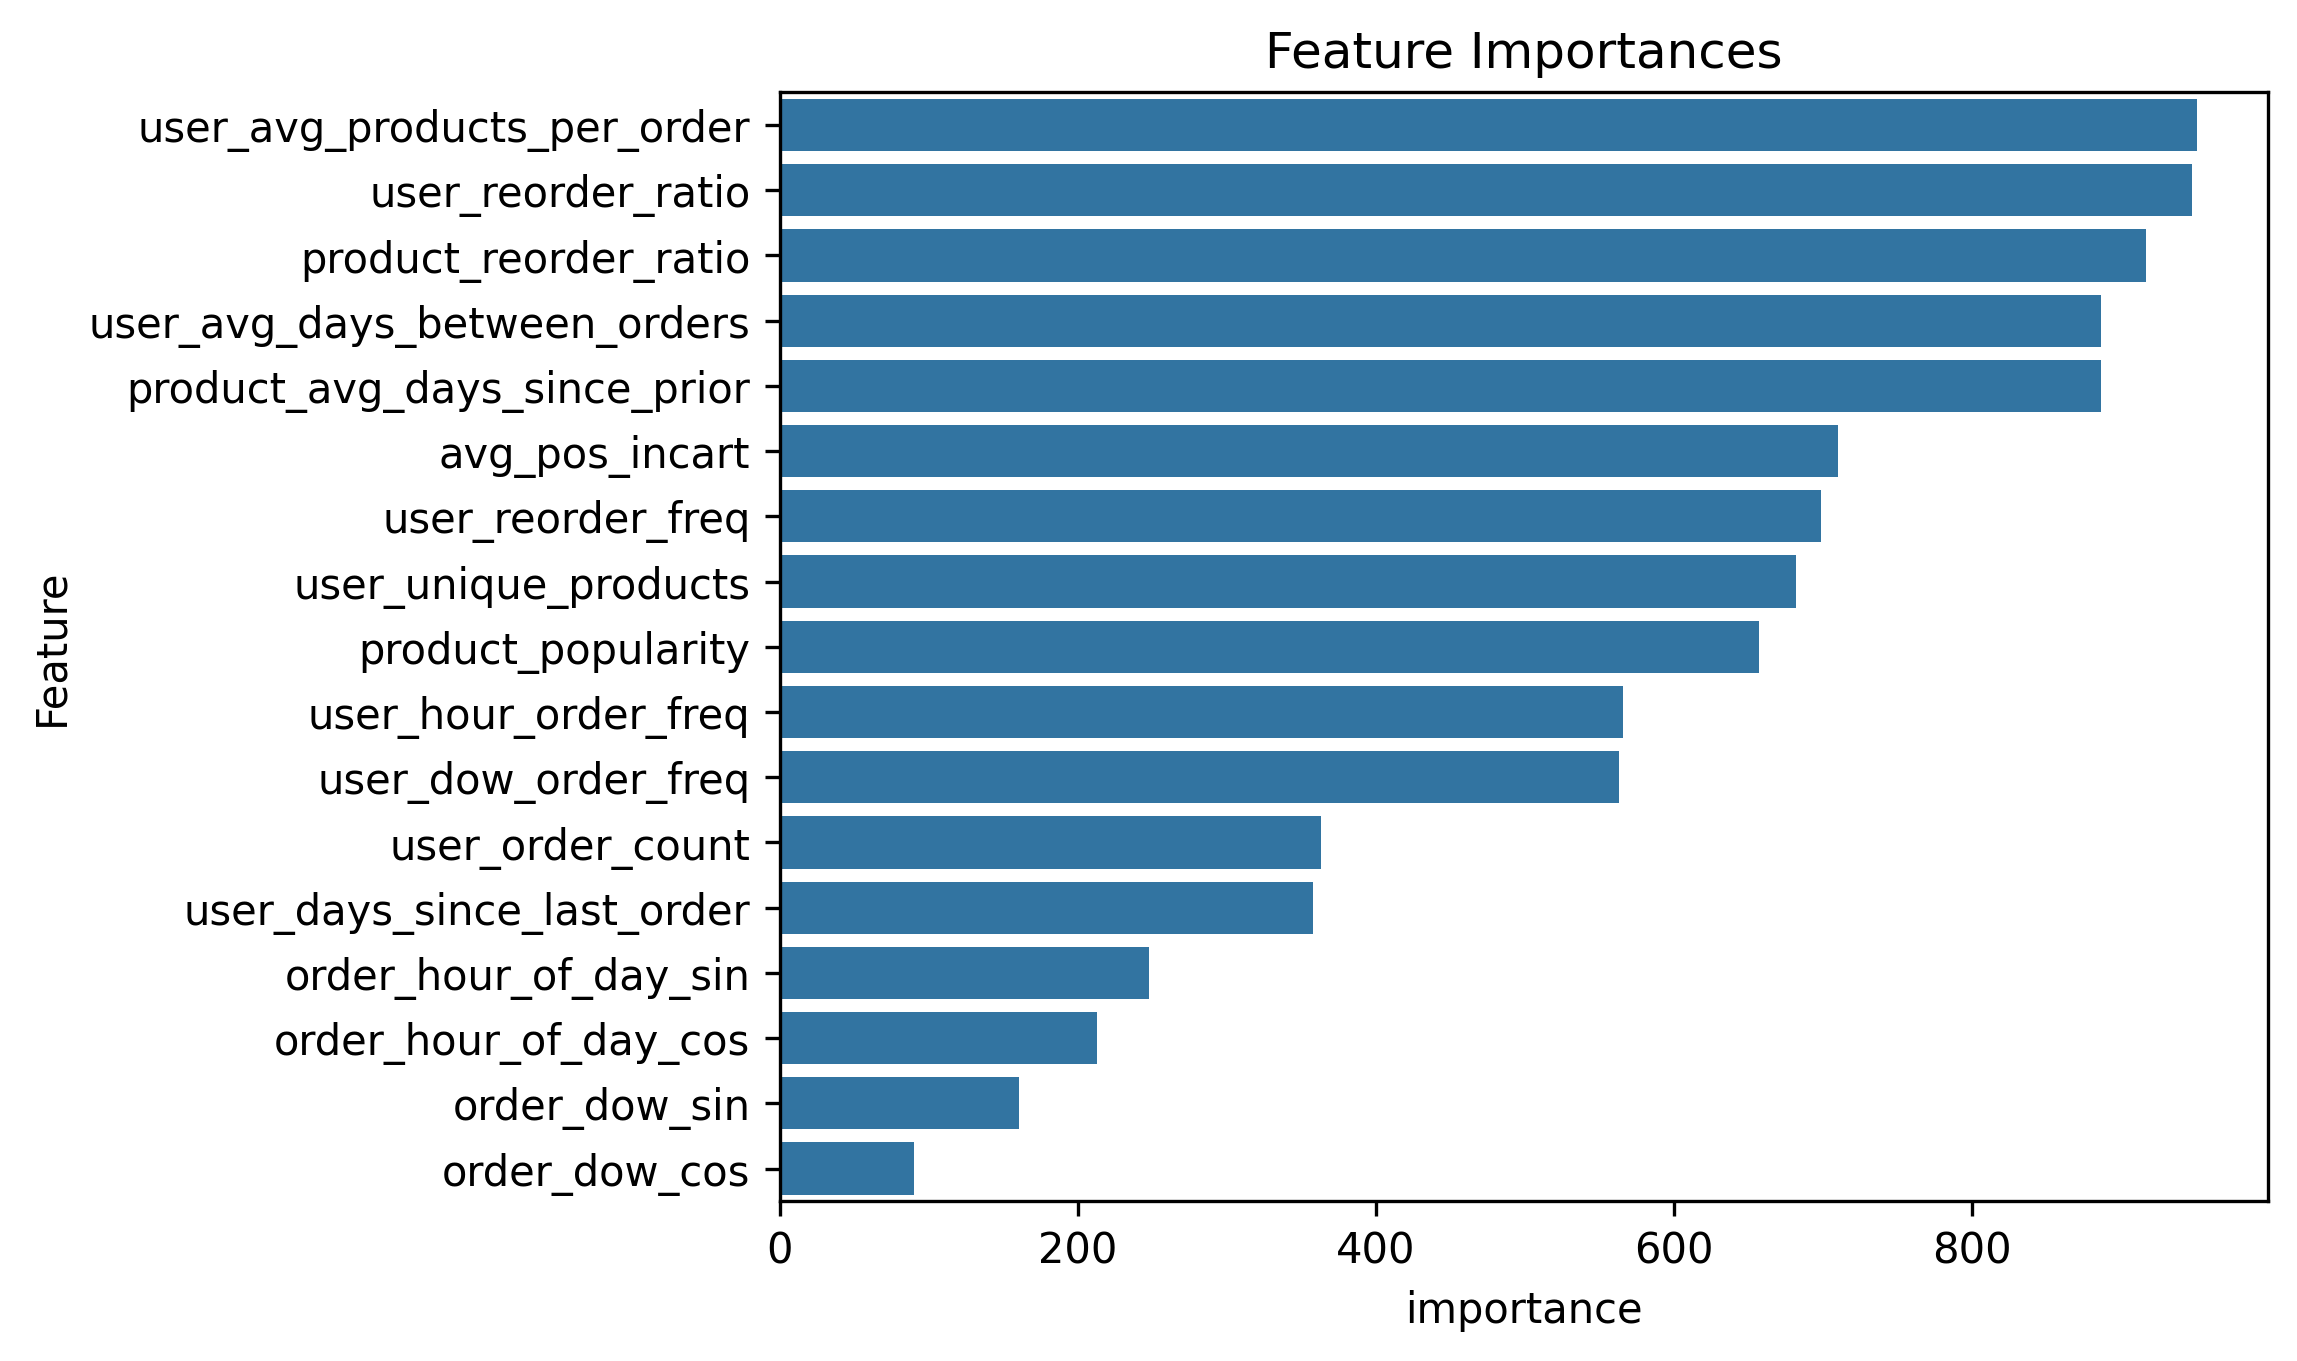

CPU times: user 50.9 s, sys: 2.13 s, total: 53 s
Wall time: 23.9 s


In [100]:
%%time
# Preprocessamento, seleção de características e treinamento
model_.preprocess()
model_.mrmr_features_select(k=40)
model_.run()

In [89]:
# Calcular a métrica do Kaggle
results_df = pd.DataFrame({
    'user_id': model_.data[model_.data['is_test'] == 1]['user_id'].values,
    'y_true': model_.y_test.values,
    'y_pred': model_.predict(model_.X_test[model_.features])
})

# Calculando métrica kaggle
f1_kaggle = instacart_f1_score(results_df, 'user_id', 'y_true', 'y_pred')
print(f"F1 Score Kaggle: {f1_kaggle:.4f}")

F1 Score Kaggle: 0.7021


Iteration: 1 / 50
Iteration: 2 / 50
Iteration: 3 / 50
Iteration: 4 / 50
Iteration: 5 / 50
Iteration: 6 / 50
Iteration: 7 / 50
Iteration: 8 / 50
Iteration: 9 / 50
Iteration: 10 / 50
Iteration: 11 / 50
Iteration: 12 / 50
Iteration: 13 / 50
Iteration: 14 / 50
Iteration: 15 / 50
Iteration: 16 / 50
Iteration: 17 / 50
Iteration: 18 / 50
Iteration: 19 / 50
Iteration: 20 / 50
Iteration: 21 / 50
Iteration: 22 / 50
Iteration: 23 / 50
Iteration: 24 / 50
Iteration: 25 / 50
Iteration: 26 / 50
Iteration: 27 / 50
Iteration: 28 / 50
Iteration: 29 / 50
Iteration: 30 / 50
Iteration: 31 / 50
Iteration: 32 / 50
Iteration: 33 / 50
Iteration: 34 / 50
Iteration: 35 / 50
Iteration: 36 / 50
Iteration: 37 / 50
Iteration: 38 / 50
Iteration: 39 / 50
Iteration: 40 / 50
Iteration: 41 / 50
Iteration: 42 / 50
Iteration: 43 / 50
Iteration: 44 / 50
Iteration: 45 / 50
Iteration: 46 / 50
Iteration: 47 / 50
Iteration: 48 / 50
Iteration: 49 / 50


BorutaPy finished running.

Iteration: 	50 / 50
Confirmed: 	8
Tentative: 	0


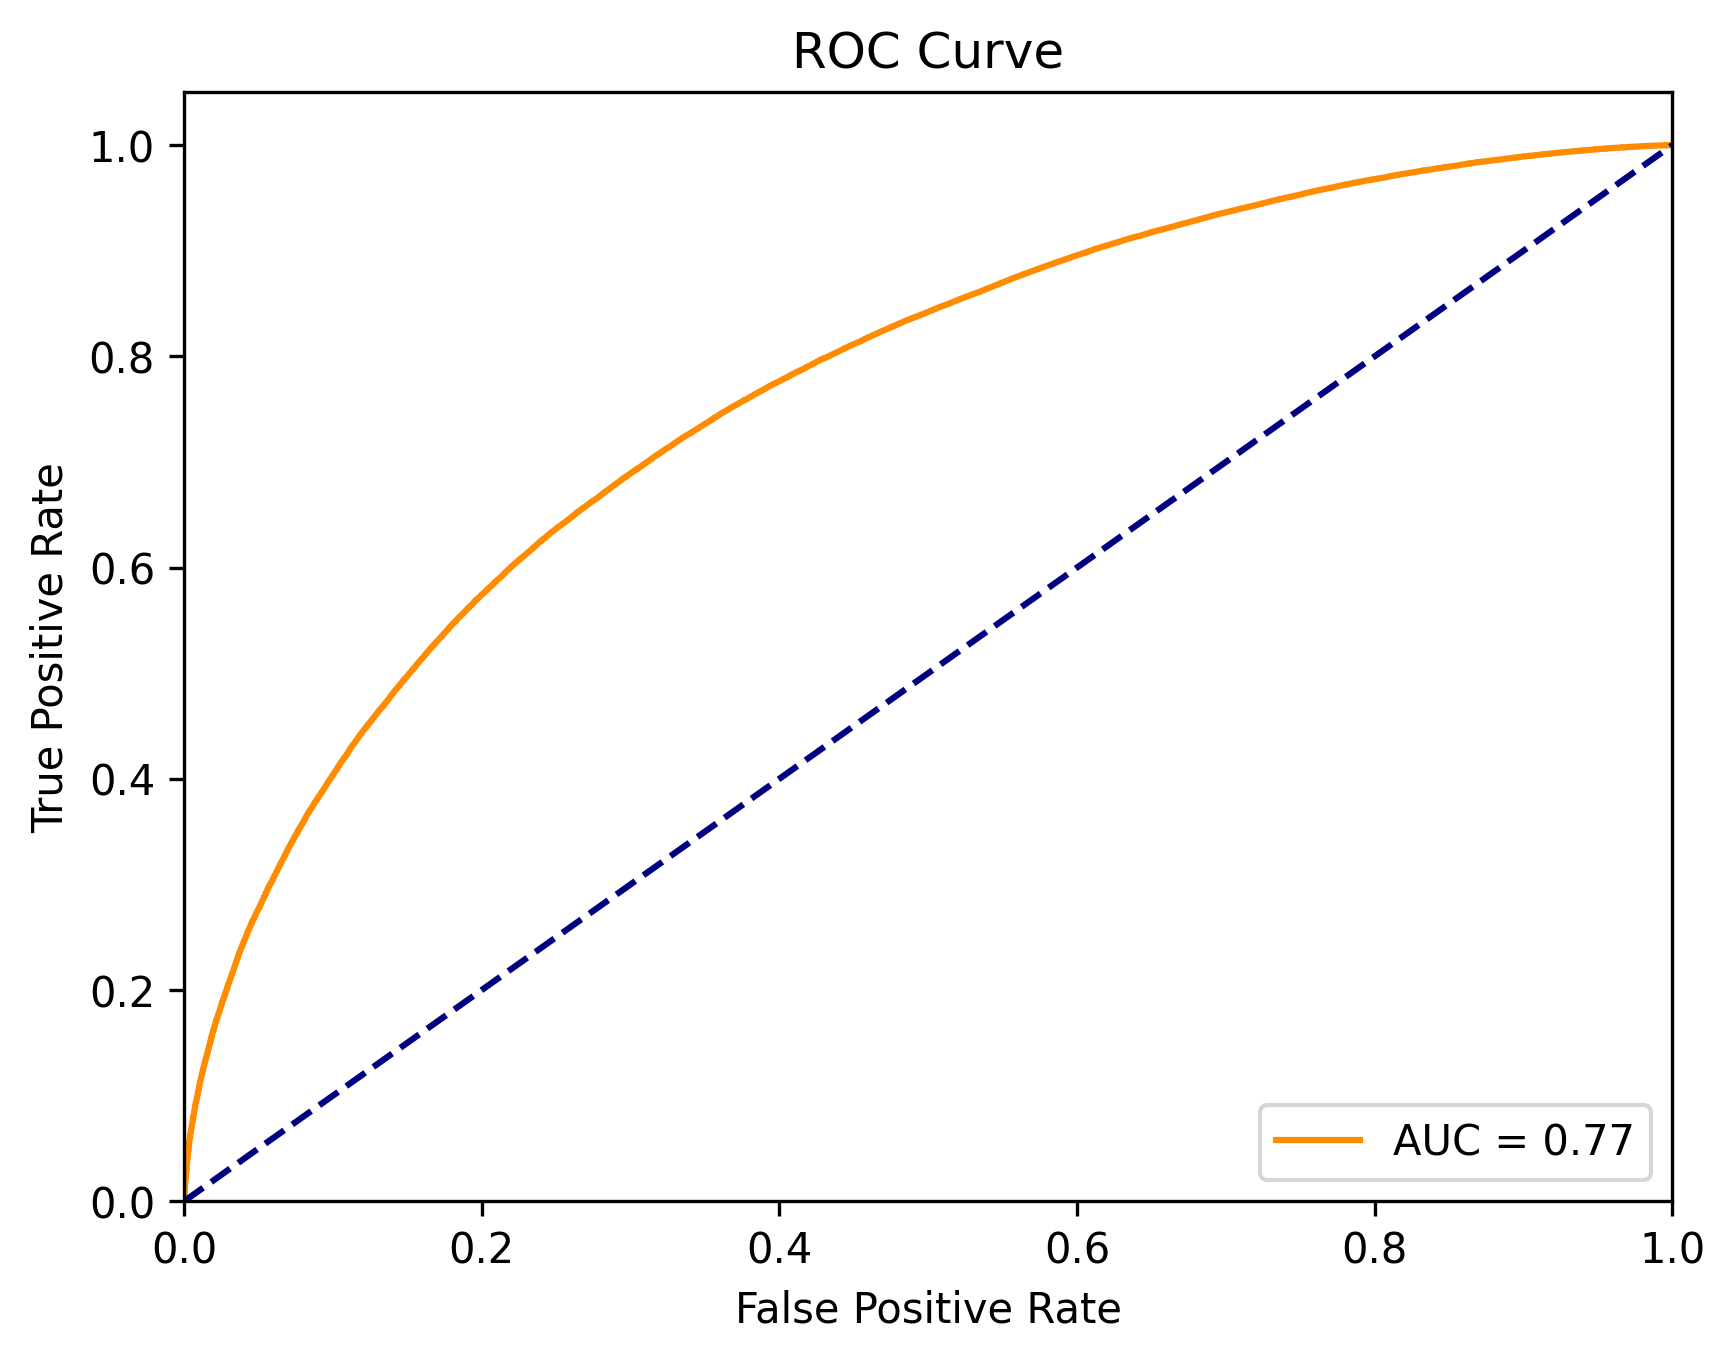

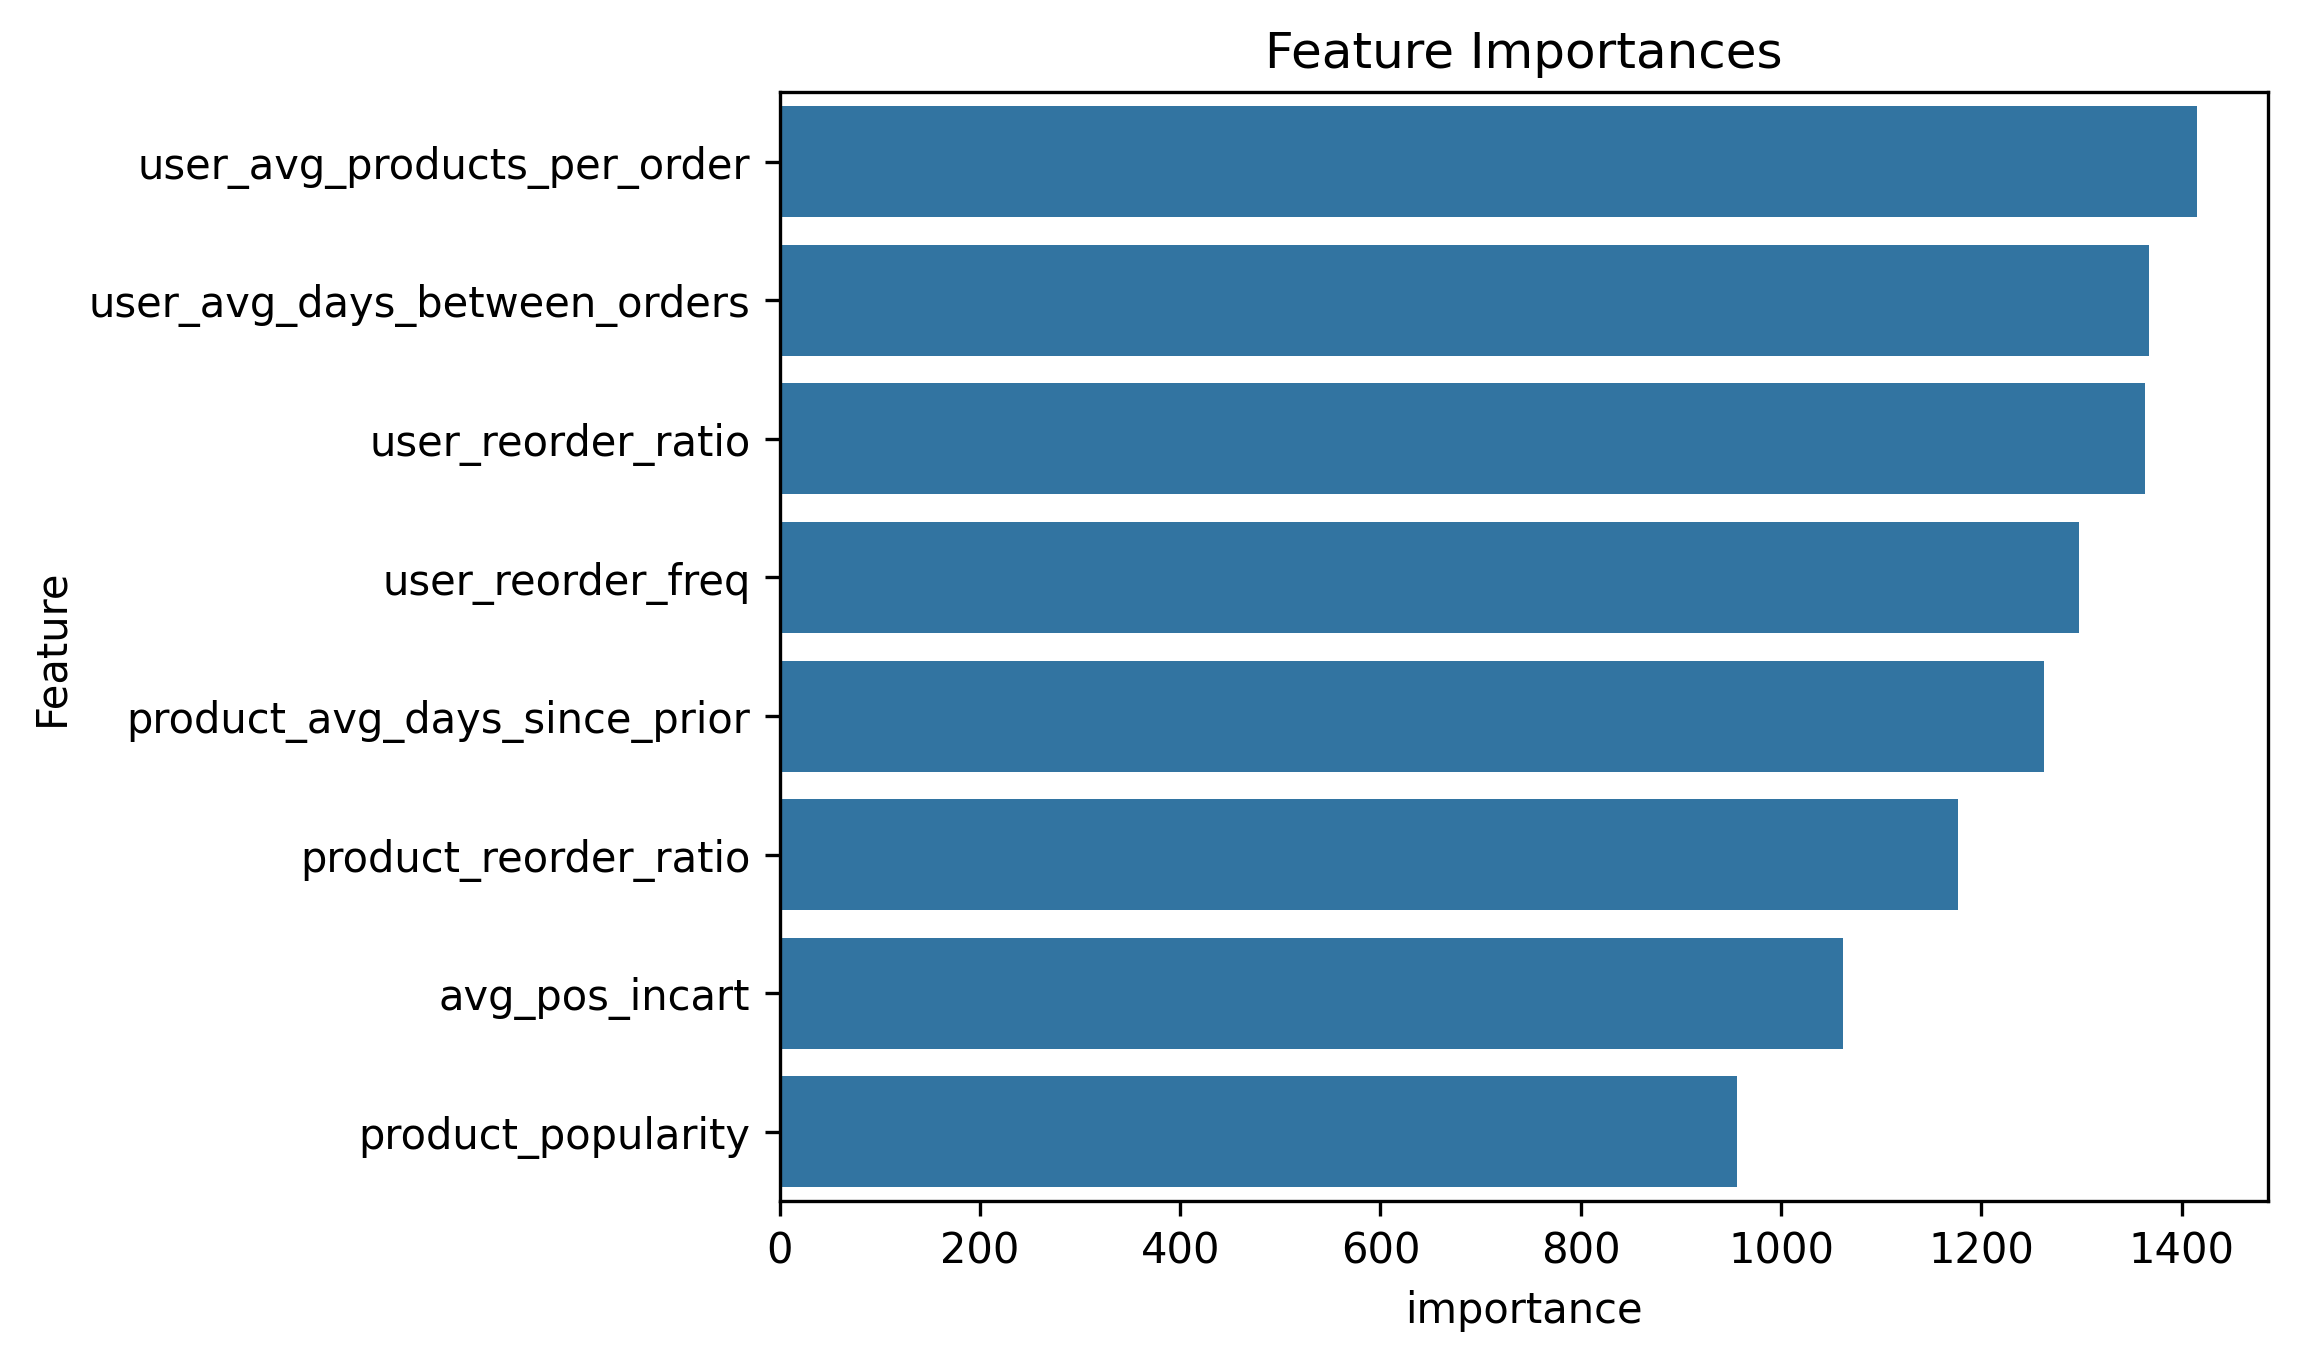

CPU times: user 4h 16min 19s, sys: 26.1 s, total: 4h 16min 45s
Wall time: 36min 33s


In [73]:
%%time
model_.preprocess()
model_.borutapy_features_select(max_iter=50)  # BorutaPy feature selection
model_.run()

In [74]:
# Calcular a métrica do Kaggle
results_df = pd.DataFrame({
    'user_id': model_.data[model_.data['is_test'] == 1]['user_id'].values,
    'y_true': model_.y_test.values,
    'y_pred': model_.predict(model_.X_test[model_.features])
})

# Calculando métrica kaggle
f1_kaggle = instacart_f1_score(results_df, 'user_id', 'y_true', 'y_pred')
print(f"F1 Score Kaggle: {f1_kaggle:.4f}")

F1 Score Kaggle: 0.7011


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 1
[LightGBM] [Info] 

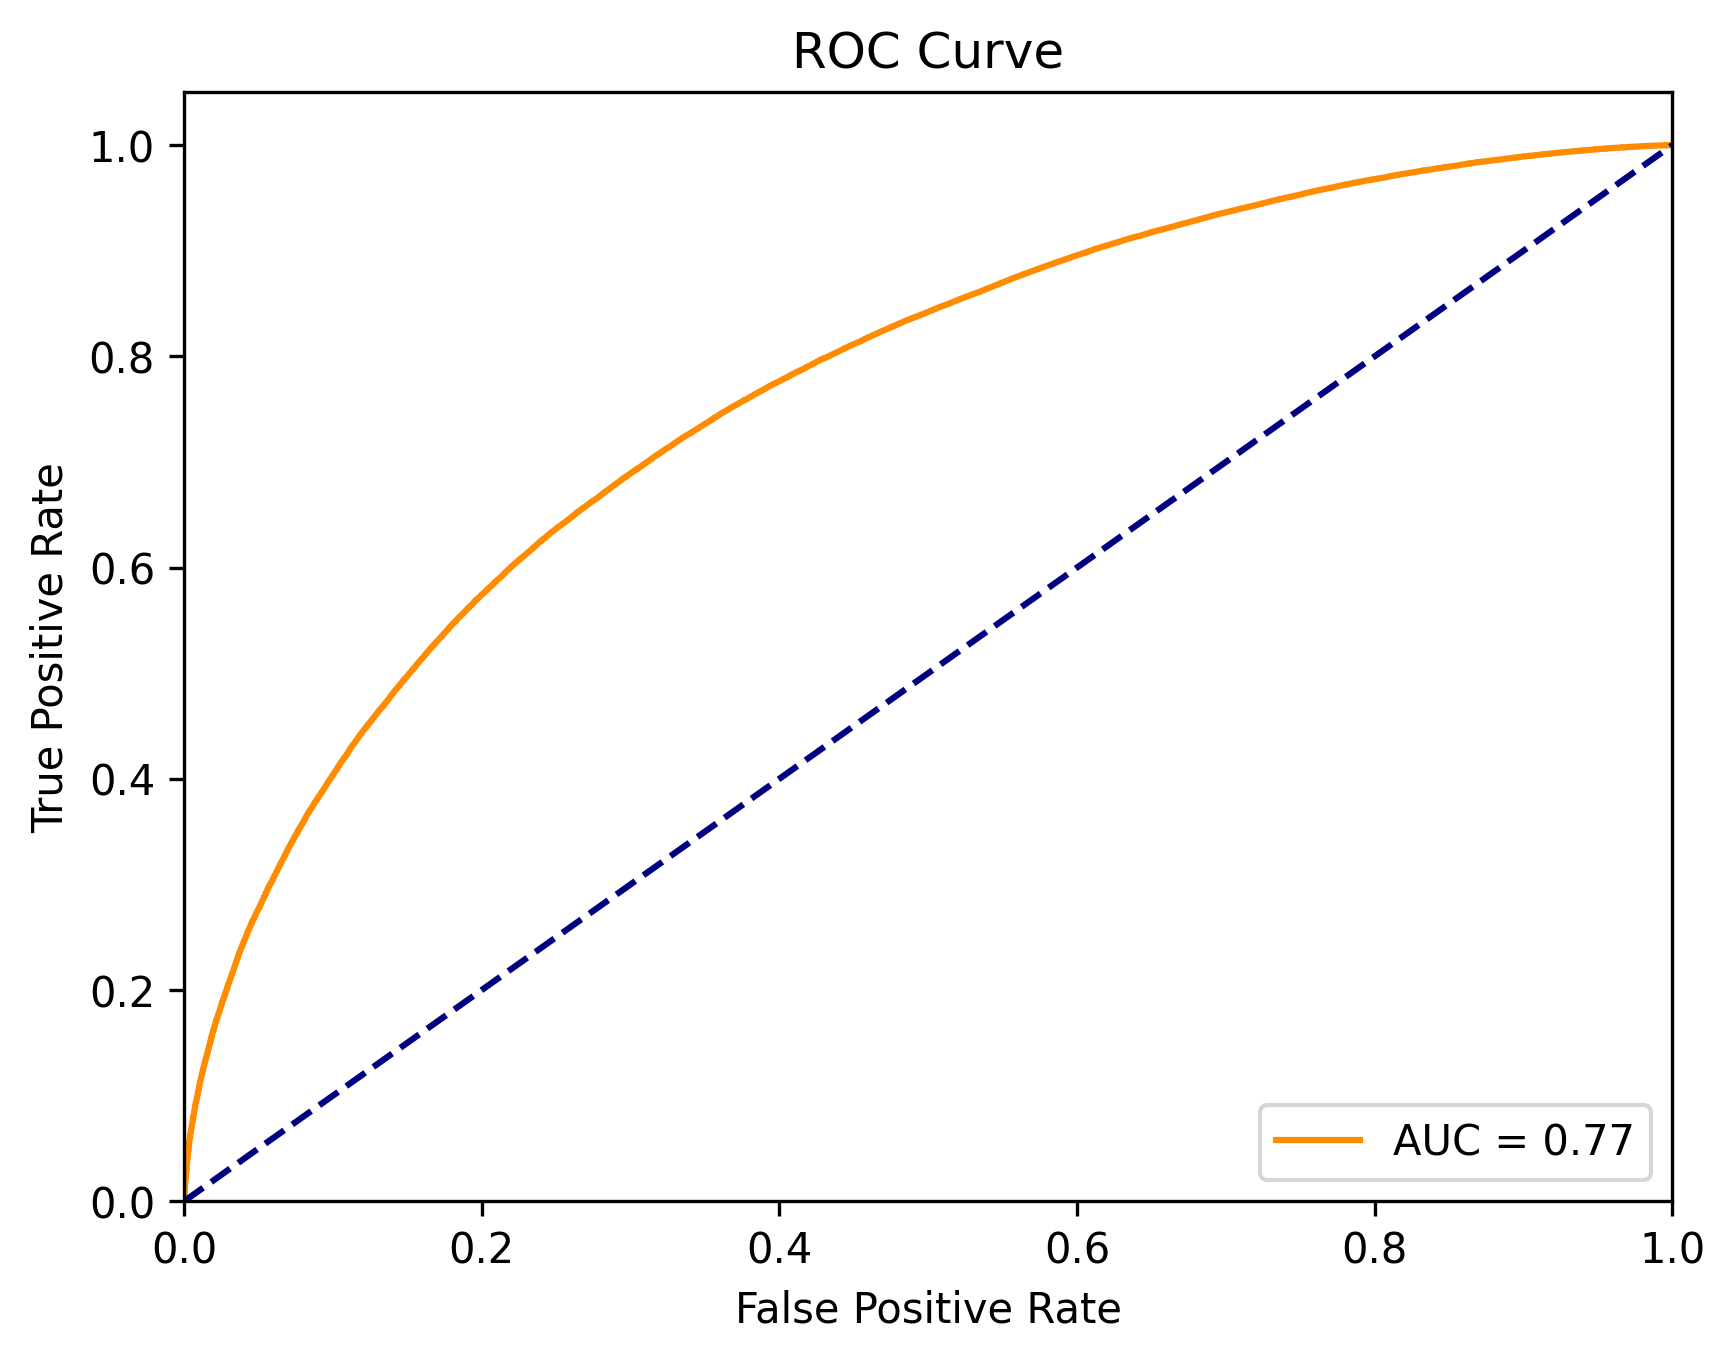

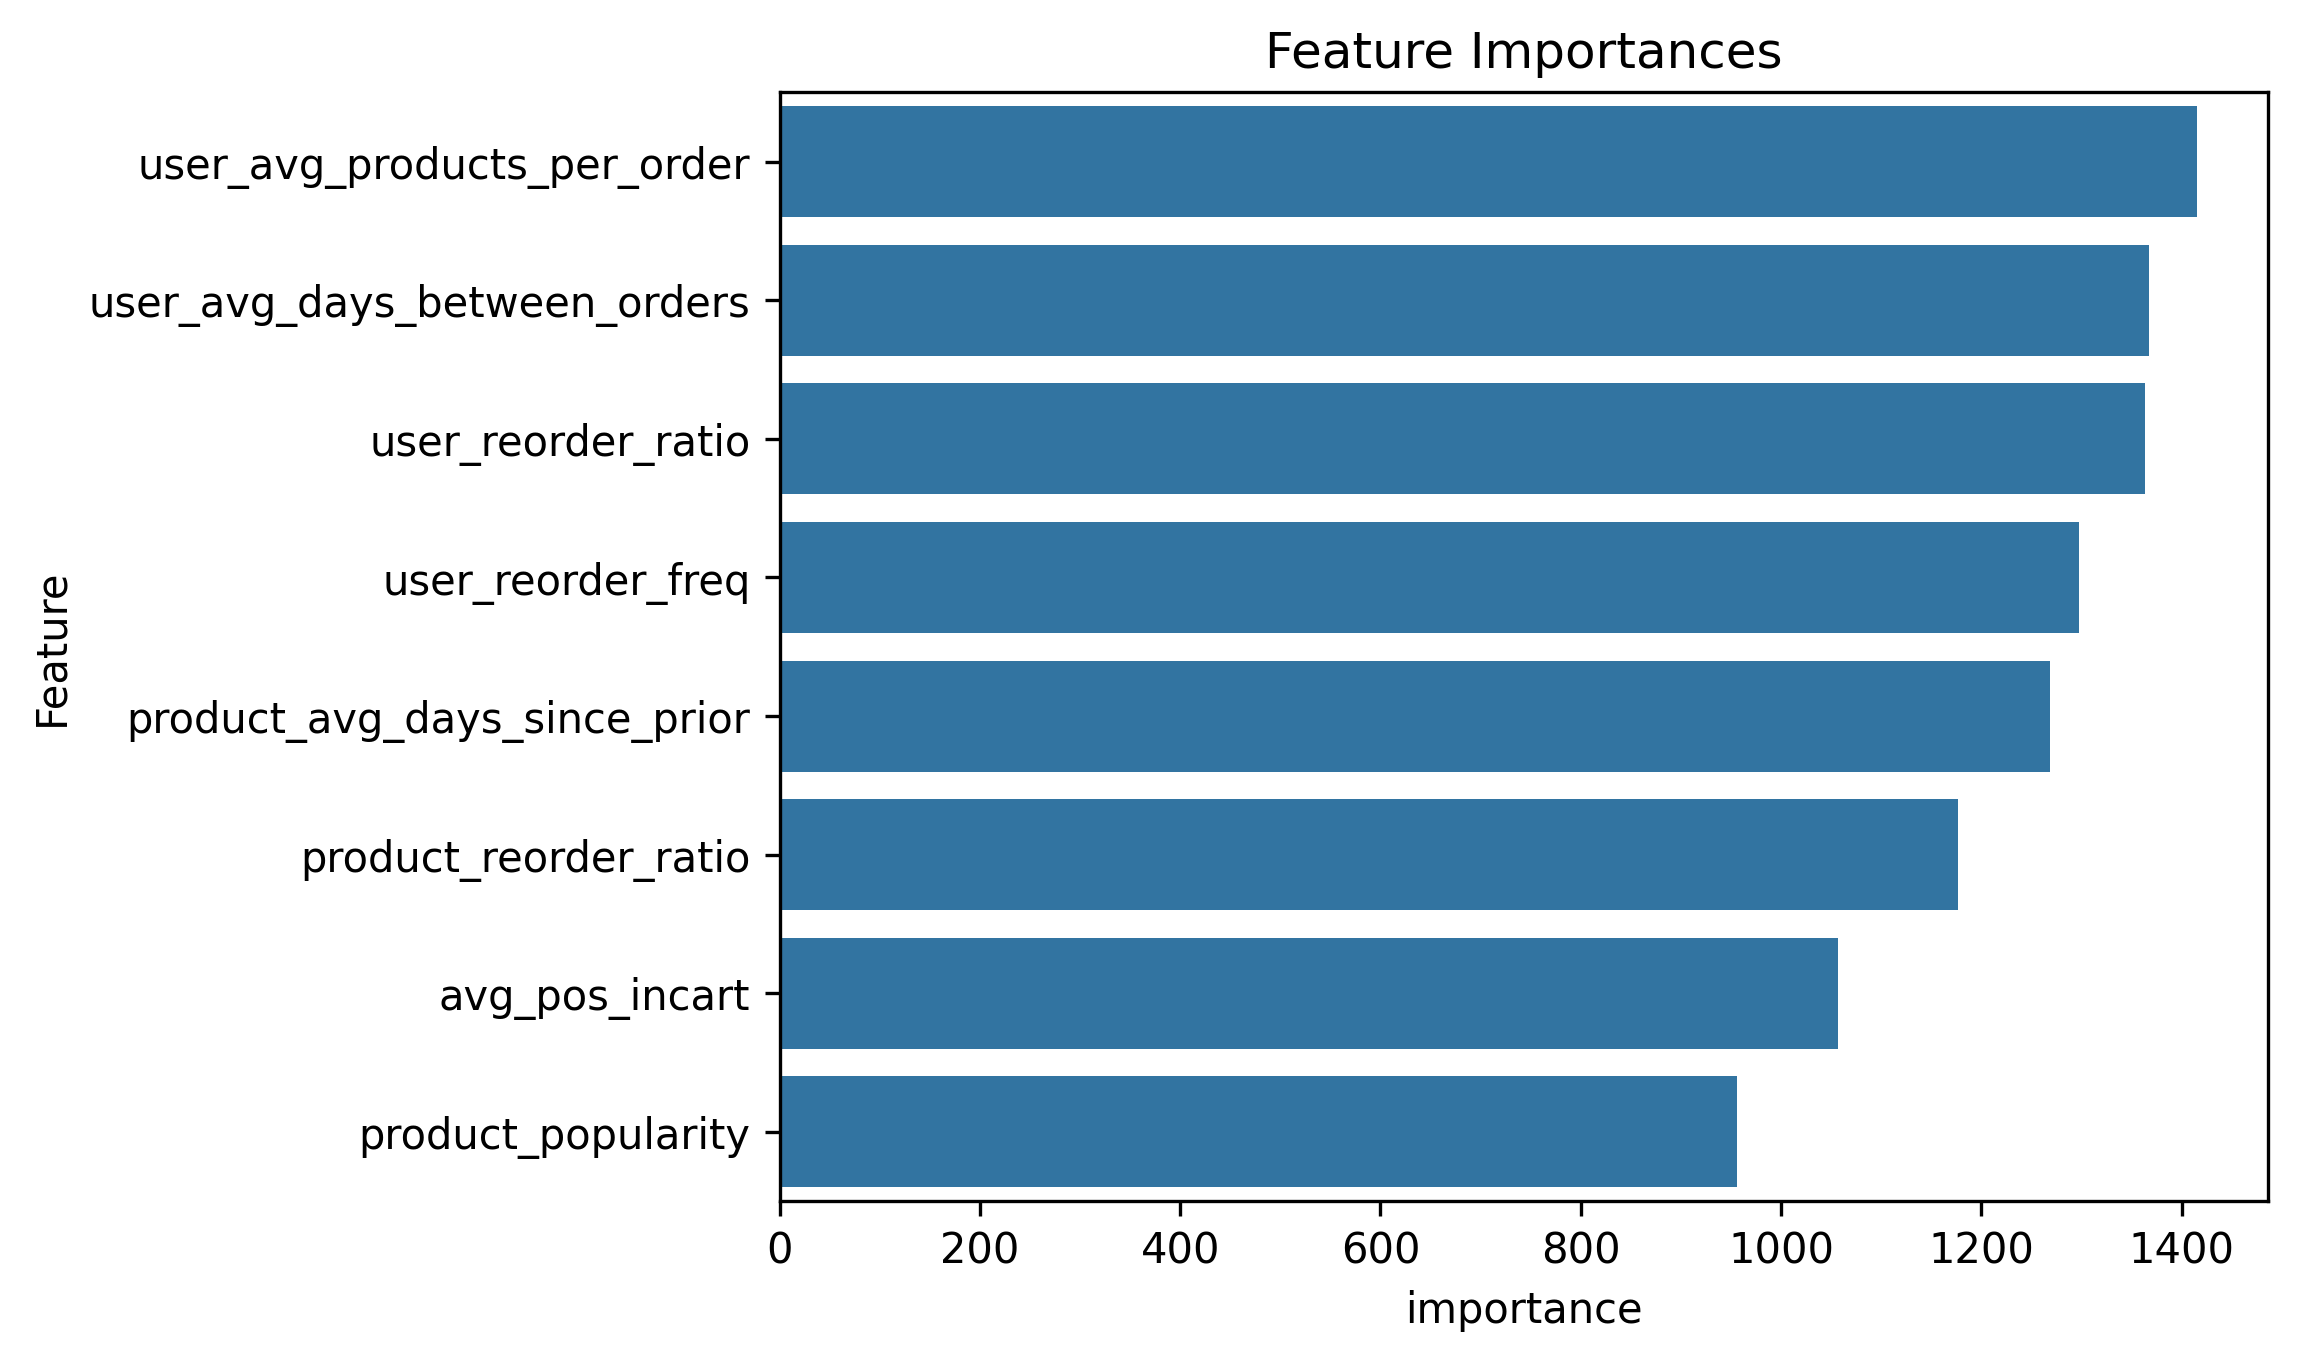

CPU times: user 22min 6s, sys: 2.47 s, total: 22min 9s
Wall time: 5min 57s


In [75]:
%%time
# Forward feature selection
model_.preprocess()
model_.forward_features_select(k_folds=5)
model_.run()

In [76]:
# Calcular a métrica do Kaggle
results_df = pd.DataFrame({
    'user_id': model_.data[model_.data['is_test'] == 1]['user_id'].values,
    'y_true': model_.y_test.values,
    'y_pred': model_.predict(model_.X_test[model_.features])
})

# Calculando métrica kaggle
f1_kaggle = instacart_f1_score(results_df, 'user_id', 'y_true', 'y_pred')
print(f"F1 Score Kaggle: {f1_kaggle:.4f}")

F1 Score Kaggle: 0.7011


[I 2024-07-22 16:34:21,405] A new study created in memory with name: no-name-126a915c-c97a-4878-b8fb-225c12431221


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:34:24,967] Trial 0 finished with value: 0.7560651140463277 and parameters: {'n_estimators': 15, 'learning_rate': 0.05800362646773561, 'num_leaves': 23, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.6349310174202343, 'colsample_bytree': 0.7648936356563205, 'reg_alpha': 0.3666200993656281, 'reg_lambda': 0.1439087549287554}. Best is trial 0 with value: 0.7560651140463277.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [

[I 2024-07-22 16:34:29,801] Trial 1 finished with value: 0.7614953489568296 and parameters: {'n_estimators': 27, 'learning_rate': 0.16726184108897982, 'num_leaves': 33, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.8654867812310099, 'colsample_bytree': 0.6715111903858678, 'reg_alpha': 0.9641226496027624, 'reg_lambda': 0.8408895338029984}. Best is trial 1 with value: 0.7614953489568296.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:34:35,992] Trial 2 finished with value: 0.762450354886014 and parameters: {'n_estimators': 35, 'learning_rate': 0.1428783755566324, 'num_leaves': 53, 'max_depth': 6, 'min_child_samples': 34, 'subsample': 0.7303502122597472, 'colsample_bytree': 0.7365123526109699, 'reg_alpha': 0.23433450580502016, 'reg_lambda': 0.2596162671327947}. Best is trial 2 with value: 0.762450354886014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[Ligh

[I 2024-07-22 16:34:41,019] Trial 3 finished with value: 0.7595710668789322 and parameters: {'n_estimators': 25, 'learning_rate': 0.061113771437998565, 'num_leaves': 52, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.80397811657245, 'colsample_bytree': 0.8190439532915604, 'reg_alpha': 0.4893269025556919, 'reg_lambda': 0.8780602755938597}. Best is trial 2 with value: 0.762450354886014.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:34:44,713] Trial 4 finished with value: 0.757857565747845 and parameters: {'n_estimators': 11, 'learning_rate': 0.029240259150351444, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.672523474195132, 'colsample_bytree': 0.8279536244796835, 'reg_alpha': 0.5852324617542448, 'reg_lambda': 0.5257022843714619}. Best is trial 2 with value: 0.762450354886014.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:34:49,852] Trial 5 finished with value: 0.7610776480705576 and parameters: {'n_estimators': 23, 'learning_rate': 0.10187348336575296, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.6674551450139501, 'colsample_bytree': 0.6437390045252767, 'reg_alpha': 0.6144180997731167, 'reg_lambda': 0.42759727160902766}. Best is trial 2 with value: 0.762450354886014.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:34:56,145] Trial 6 finished with value: 0.7575037716376489 and parameters: {'n_estimators': 46, 'learning_rate': 0.04318915538510576, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 35, 'subsample': 0.6592089941693033, 'colsample_bytree': 0.743331284865131, 'reg_alpha': 0.010950167048828648, 'reg_lambda': 0.4478652996317515}. Best is trial 2 with value: 0.762450354886014.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:35:02,242] Trial 7 finished with value: 0.7634827075421069 and parameters: {'n_estimators': 32, 'learning_rate': 0.19587932525196852, 'num_leaves': 68, 'max_depth': 13, 'min_child_samples': 42, 'subsample': 0.8327146184395704, 'colsample_bytree': 0.8908997058060995, 'reg_alpha': 0.70846083379292, 'reg_lambda': 0.5306305735263945}. Best is trial 7 with value: 0.7634827075421069.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:35:07,140] Trial 8 finished with value: 0.7612914406267428 and parameters: {'n_estimators': 25, 'learning_rate': 0.15603023941117064, 'num_leaves': 25, 'max_depth': 13, 'min_child_samples': 32, 'subsample': 0.7511927543781334, 'colsample_bytree': 0.6351306950885033, 'reg_alpha': 0.274933164005567, 'reg_lambda': 0.036309601874046596}. Best is trial 7 with value: 0.7634827075421069.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:35:14,160] Trial 9 finished with value: 0.7584364465849183 and parameters: {'n_estimators': 40, 'learning_rate': 0.023738369363166794, 'num_leaves': 40, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.697885743528782, 'colsample_bytree': 0.7729565719901215, 'reg_alpha': 0.7574582134848382, 'reg_lambda': 0.9188673751005367}. Best is trial 7 with value: 0.7634827075421069.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:35:21,928] Trial 10 finished with value: 0.7638883654586386 and parameters: {'n_estimators': 50, 'learning_rate': 0.1989758639228316, 'num_leaves': 73, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.8897375124947483, 'colsample_bytree': 0.8942275463939837, 'reg_alpha': 0.9654115535222126, 'reg_lambda': 0.6564450573077665}. Best is trial 10 with value: 0.7638883654586386.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:35:29,685] Trial 11 finished with value: 0.7637986163121161 and parameters: {'n_estimators': 47, 'learning_rate': 0.1928453797396783, 'num_leaves': 73, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.8958638596138042, 'colsample_bytree': 0.8871174236504087, 'reg_alpha': 0.997930235691464, 'reg_lambda': 0.663045058240082}. Best is trial 10 with value: 0.7638883654586386.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:35:37,226] Trial 12 finished with value: 0.7638706002365644 and parameters: {'n_estimators': 49, 'learning_rate': 0.19597373531263013, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.8981070540231795, 'colsample_bytree': 0.8909390107070132, 'reg_alpha': 0.9655032119107694, 'reg_lambda': 0.6972013820887081}. Best is trial 10 with value: 0.7638883654586386.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:35:44,956] Trial 13 finished with value: 0.7630975993299514 and parameters: {'n_estimators': 41, 'learning_rate': 0.12261793896514099, 'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.8994585040121579, 'colsample_bytree': 0.8432049489416258, 'reg_alpha': 0.8470835473658349, 'reg_lambda': 0.6923484370531217}. Best is trial 10 with value: 0.7638883654586386.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:35:53,273] Trial 14 finished with value: 0.7639403490380742 and parameters: {'n_estimators': 50, 'learning_rate': 0.17755863876477146, 'num_leaves': 79, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.788357862208942, 'colsample_bytree': 0.8616200159855776, 'reg_alpha': 0.881714117064086, 'reg_lambda': 0.711878400616064}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:36:01,320] Trial 15 finished with value: 0.7627863098171047 and parameters: {'n_estimators': 42, 'learning_rate': 0.09470096553707955, 'num_leaves': 65, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.7908790298861954, 'colsample_bytree': 0.8517685764756029, 'reg_alpha': 0.8339727400261175, 'reg_lambda': 0.7706830566142857}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:36:09,785] Trial 16 finished with value: 0.7638654444493309 and parameters: {'n_estimators': 50, 'learning_rate': 0.1695256919276974, 'num_leaves': 73, 'max_depth': 15, 'min_child_samples': 43, 'subsample': 0.8461187586501198, 'colsample_bytree': 0.7926105683550099, 'reg_alpha': 0.8439392023634252, 'reg_lambda': 0.9876343345504165}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:36:16,772] Trial 17 finished with value: 0.7628231225656926 and parameters: {'n_estimators': 36, 'learning_rate': 0.13837312678335079, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 41, 'subsample': 0.7728526881273842, 'colsample_bytree': 0.7005162108926022, 'reg_alpha': 0.7074183655045088, 'reg_lambda': 0.5730837008611542}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:36:24,159] Trial 18 finished with value: 0.7637233198989518 and parameters: {'n_estimators': 43, 'learning_rate': 0.17622308520260996, 'num_leaves': 74, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8162690831268817, 'colsample_bytree': 0.8597774738728592, 'reg_alpha': 0.47266972673219304, 'reg_lambda': 0.34934894212062056}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:36:31,097] Trial 19 finished with value: 0.7625846468384239 and parameters: {'n_estimators': 37, 'learning_rate': 0.12754812455142742, 'num_leaves': 43, 'max_depth': 8, 'min_child_samples': 46, 'subsample': 0.7188895109483473, 'colsample_bytree': 0.8169891236306357, 'reg_alpha': 0.8825029352652823, 'reg_lambda': 0.6267671962798261}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:36:39,639] Trial 20 finished with value: 0.7625832772990464 and parameters: {'n_estimators': 45, 'learning_rate': 0.08333052766345315, 'num_leaves': 61, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.8627260900196355, 'colsample_bytree': 0.8643515341369583, 'reg_alpha': 0.6376342576164341, 'reg_lambda': 0.786153487414888}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:36:47,472] Trial 21 finished with value: 0.7638962811521023 and parameters: {'n_estimators': 50, 'learning_rate': 0.19691682488391143, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 47, 'subsample': 0.865710730145609, 'colsample_bytree': 0.8957750091025292, 'reg_alpha': 0.9279738064442828, 'reg_lambda': 0.7358099628697831}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:36:55,759] Trial 22 finished with value: 0.7639218447383088 and parameters: {'n_estimators': 50, 'learning_rate': 0.18030502492345646, 'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.8654157776095185, 'colsample_bytree': 0.898459721819602, 'reg_alpha': 0.9001784700496872, 'reg_lambda': 0.7150721831312654}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhea

[I 2024-07-22 16:37:03,396] Trial 23 finished with value: 0.763591052554489 and parameters: {'n_estimators': 45, 'learning_rate': 0.17558100896675227, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 38, 'subsample': 0.8360325096216731, 'colsample_bytree': 0.8697806595294969, 'reg_alpha': 0.75555656293577, 'reg_lambda': 0.759225367428032}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:37:08,098] Trial 24 finished with value: 0.7616802492165403 and parameters: {'n_estimators': 19, 'learning_rate': 0.15412704178609485, 'num_leaves': 69, 'max_depth': 11, 'min_child_samples': 46, 'subsample': 0.779566263537259, 'colsample_bytree': 0.6062713257087888, 'reg_alpha': 0.8906248122356322, 'reg_lambda': 0.822234577986462}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:37:15,995] Trial 25 finished with value: 0.7637468056016239 and parameters: {'n_estimators': 47, 'learning_rate': 0.18237980249143662, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 39, 'subsample': 0.8665640172209259, 'colsample_bytree': 0.795926346897157, 'reg_alpha': 0.7728779519861165, 'reg_lambda': 0.9158167803693027}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:37:23,211] Trial 26 finished with value: 0.7634784367450995 and parameters: {'n_estimators': 39, 'learning_rate': 0.15818145035653405, 'num_leaves': 69, 'max_depth': 12, 'min_child_samples': 46, 'subsample': 0.8108603907160915, 'colsample_bytree': 0.8383237459692232, 'reg_alpha': 0.9199503137191047, 'reg_lambda': 0.602777324494735}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:37:30,170] Trial 27 finished with value: 0.7628280847532496 and parameters: {'n_estimators': 33, 'learning_rate': 0.1171278414088403, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.7595882279554769, 'colsample_bytree': 0.8729947393937265, 'reg_alpha': 0.8240880171724543, 'reg_lambda': 0.9994721713066996}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:37:35,042] Trial 28 finished with value: 0.7606790507375487 and parameters: {'n_estimators': 44, 'learning_rate': 0.1422474821083879, 'num_leaves': 47, 'max_depth': 3, 'min_child_samples': 40, 'subsample': 0.6060591294120633, 'colsample_bytree': 0.7195570437386977, 'reg_alpha': 0.6760019584190085, 'reg_lambda': 0.7409966884570718}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:37:43,056] Trial 29 finished with value: 0.7636732754027568 and parameters: {'n_estimators': 50, 'learning_rate': 0.18401979004787952, 'num_leaves': 65, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.8492191158255705, 'colsample_bytree': 0.7998269685717563, 'reg_alpha': 0.40039959926638835, 'reg_lambda': 0.4179681513008739}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:37:51,077] Trial 30 finished with value: 0.7624344855060767 and parameters: {'n_estimators': 39, 'learning_rate': 0.07987960317128799, 'num_leaves': 80, 'max_depth': 15, 'min_child_samples': 47, 'subsample': 0.8209389716509157, 'colsample_bytree': 0.8997860580151139, 'reg_alpha': 0.5333701174174201, 'reg_lambda': 0.7152528630373078}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:37:58,487] Trial 31 finished with value: 0.7637425499432975 and parameters: {'n_estimators': 48, 'learning_rate': 0.1983376870875487, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 49, 'subsample': 0.8805624229648499, 'colsample_bytree': 0.874271266666657, 'reg_alpha': 0.9326377464837088, 'reg_lambda': 0.6266388412172218}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:38:06,967] Trial 32 finished with value: 0.7638514502126925 and parameters: {'n_estimators': 50, 'learning_rate': 0.1649337714110175, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 48, 'subsample': 0.872367778191495, 'colsample_bytree': 0.8987572447760299, 'reg_alpha': 0.9996713856103858, 'reg_lambda': 0.8458356055606895}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:38:14,605] Trial 33 finished with value: 0.7638100929669802 and parameters: {'n_estimators': 48, 'learning_rate': 0.190940149512056, 'num_leaves': 70, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.8532355629817713, 'colsample_bytree': 0.8531740489431422, 'reg_alpha': 0.9258804796358588, 'reg_lambda': 0.5754822074993429}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

[I 2024-07-22 16:38:21,576] Trial 34 finished with value: 0.7636131383392376 and parameters: {'n_estimators': 43, 'learning_rate': 0.1844208172063842, 'num_leaves': 76, 'max_depth': 7, 'min_child_samples': 36, 'subsample': 0.8808224822019469, 'colsample_bytree': 0.8869003158364821, 'reg_alpha': 0.8052240586212082, 'reg_lambda': 0.6442593136016982}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:38:28,375] Trial 35 finished with value: 0.7625776681316345 and parameters: {'n_estimators': 46, 'learning_rate': 0.17162082494830702, 'num_leaves': 21, 'max_depth': 7, 'min_child_samples': 48, 'subsample': 0.8245053953779244, 'colsample_bytree': 0.8743487443235038, 'reg_alpha': 0.8989886279568359, 'reg_lambda': 0.8117689177301997}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:38:34,363] Trial 36 finished with value: 0.7628897730320079 and parameters: {'n_estimators': 28, 'learning_rate': 0.14970201472547323, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 41, 'subsample': 0.7886419135123677, 'colsample_bytree': 0.840900133919231, 'reg_alpha': 0.9598832200854546, 'reg_lambda': 0.4793221584895342}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:38:38,271] Trial 37 finished with value: 0.7605618762688078 and parameters: {'n_estimators': 14, 'learning_rate': 0.1654348070987796, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.8006521206942661, 'colsample_bytree': 0.8082329108590298, 'reg_alpha': 0.1665251884455256, 'reg_lambda': 0.350619355885375}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (nu

[I 2024-07-22 16:38:45,488] Trial 38 finished with value: 0.7631357491318032 and parameters: {'n_estimators': 50, 'learning_rate': 0.1837784233489828, 'num_leaves': 31, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.88228839765069, 'colsample_bytree': 0.7753146249262404, 'reg_alpha': 0.8701412278650067, 'reg_lambda': 0.8865412167553061}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [In

[I 2024-07-22 16:38:54,670] Trial 39 finished with value: 0.7584908069954526 and parameters: {'n_estimators': 47, 'learning_rate': 0.010356873804882483, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 43, 'subsample': 0.8515323493925769, 'colsample_bytree': 0.8288995300059266, 'reg_alpha': 0.5658595845188589, 'reg_lambda': 0.5318538559868033}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:38:59,554] Trial 40 finished with value: 0.7595779548437397 and parameters: {'n_estimators': 21, 'learning_rate': 0.05889153223525472, 'num_leaves': 63, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.6904432333143009, 'colsample_bytree': 0.8793038964923172, 'reg_alpha': 0.7747476420229875, 'reg_lambda': 0.6709023002120377}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:39:07,327] Trial 41 finished with value: 0.7639383200313358 and parameters: {'n_estimators': 49, 'learning_rate': 0.19914803551090043, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.8982165971427143, 'colsample_bytree': 0.8956541479262952, 'reg_alpha': 0.9603999617469149, 'reg_lambda': 0.6985296371970985}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:39:15,157] Trial 42 finished with value: 0.7638497254737413 and parameters: {'n_estimators': 48, 'learning_rate': 0.189192188167954, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 48, 'subsample': 0.8866257760607261, 'colsample_bytree': 0.8999234466629862, 'reg_alpha': 0.9665247889322428, 'reg_lambda': 0.7377782594150075}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:39:22,409] Trial 43 finished with value: 0.7637701543916222 and parameters: {'n_estimators': 45, 'learning_rate': 0.19761798587415458, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 50, 'subsample': 0.8355534263576988, 'colsample_bytree': 0.8581099642092814, 'reg_alpha': 0.9449425889014155, 'reg_lambda': 0.5780717565252786}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:39:30,573] Trial 44 finished with value: 0.7639169320459585 and parameters: {'n_estimators': 50, 'learning_rate': 0.17901409148471029, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.7272875337247948, 'colsample_bytree': 0.8856849705998447, 'reg_alpha': 0.9843431518837894, 'reg_lambda': 0.7142918113820785}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:39:38,558] Trial 45 finished with value: 0.7638272376178639 and parameters: {'n_estimators': 48, 'learning_rate': 0.1770251961730315, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.720971893524083, 'colsample_bytree': 0.8864086534587666, 'reg_alpha': 0.9945988644623733, 'reg_lambda': 0.11916281466079132}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-22 16:39:44,706] Trial 46 finished with value: 0.7625286829268423 and parameters: {'n_estimators': 42, 'learning_rate': 0.1599407659579558, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 44, 'subsample': 0.7462610717175255, 'colsample_bytree': 0.8273280407449436, 'reg_alpha': 0.892011568519733, 'reg_lambda': 0.8623545856011388}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[LightGBM] [Info] Start training from score 0.398699
[LightGBM] [

[I 2024-07-22 16:39:52,870] Trial 47 finished with value: 0.7634298327552046 and parameters: {'n_estimators': 45, 'learning_rate': 0.14910480041789556, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.739478443835227, 'colsample_bytree': 0.67388911572221, 'reg_alpha': 0.8061935185595226, 'reg_lambda': 0.791896301231041}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775385, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398699
[

[I 2024-07-22 16:40:00,421] Trial 48 finished with value: 0.7637775849922729 and parameters: {'n_estimators': 47, 'learning_rate': 0.18929030577328732, 'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 42, 'subsample': 0.6390315616478184, 'colsample_bytree': 0.8800781947509776, 'reg_alpha': 0.03161253379374479, 'reg_lambda': 0.7249621460069402}. Best is trial 14 with value: 0.7639403490380742.


[LightGBM] [Info] Number of positive: 463971, number of negative: 311413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 775384, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598376 -> initscore=0.398702
[LightGBM] [Info] Start training from score 0.398702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 463971, number of negative: 311414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012215 seconds.
You can set `force_col_wise=t

[I 2024-07-22 16:40:08,546] Trial 49 finished with value: 0.7634780876297457 and parameters: {'n_estimators': 50, 'learning_rate': 0.13303365694623528, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 48, 'subsample': 0.6957235448660285, 'colsample_bytree': 0.8481708530384193, 'reg_alpha': 0.7043329140141479, 'reg_lambda': 0.6759155727030942}. Best is trial 14 with value: 0.7639403490380742.


Best parameters (Optuna): {'n_estimators': 50, 'learning_rate': 0.17755863876477146, 'num_leaves': 79, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.788357862208942, 'colsample_bytree': 0.8616200159855776, 'reg_alpha': 0.881714117064086, 'reg_lambda': 0.711878400616064}
[LightGBM] [Info] Number of positive: 579964, number of negative: 389267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 969231, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598375 -> initscore=0.398701
[LightGBM] [Info] Start training from score 0.398701
Removed constant features: []
Removed correlated features: []
[LightGBM] [Info] Number of positive: 579964, number of negative: 389267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0

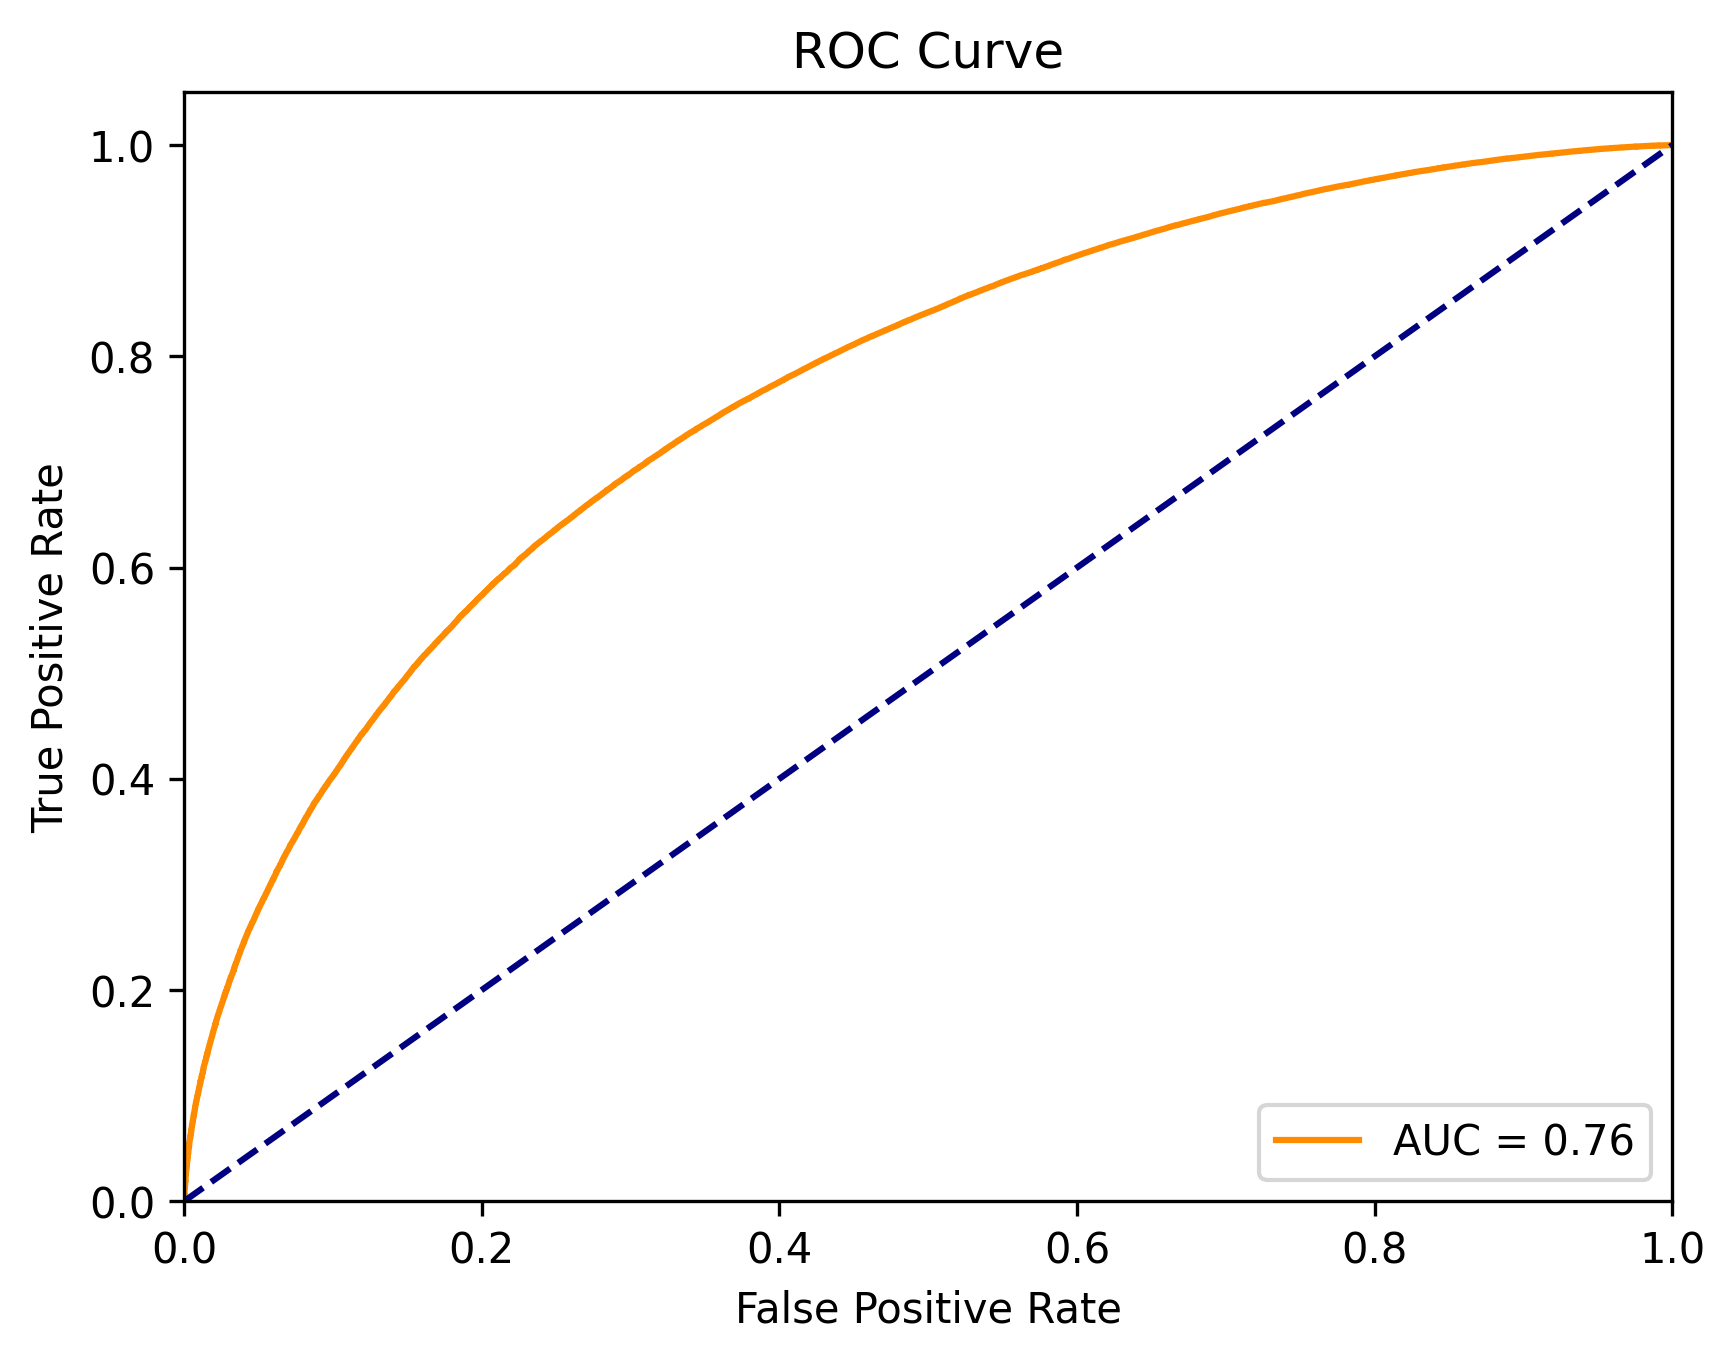

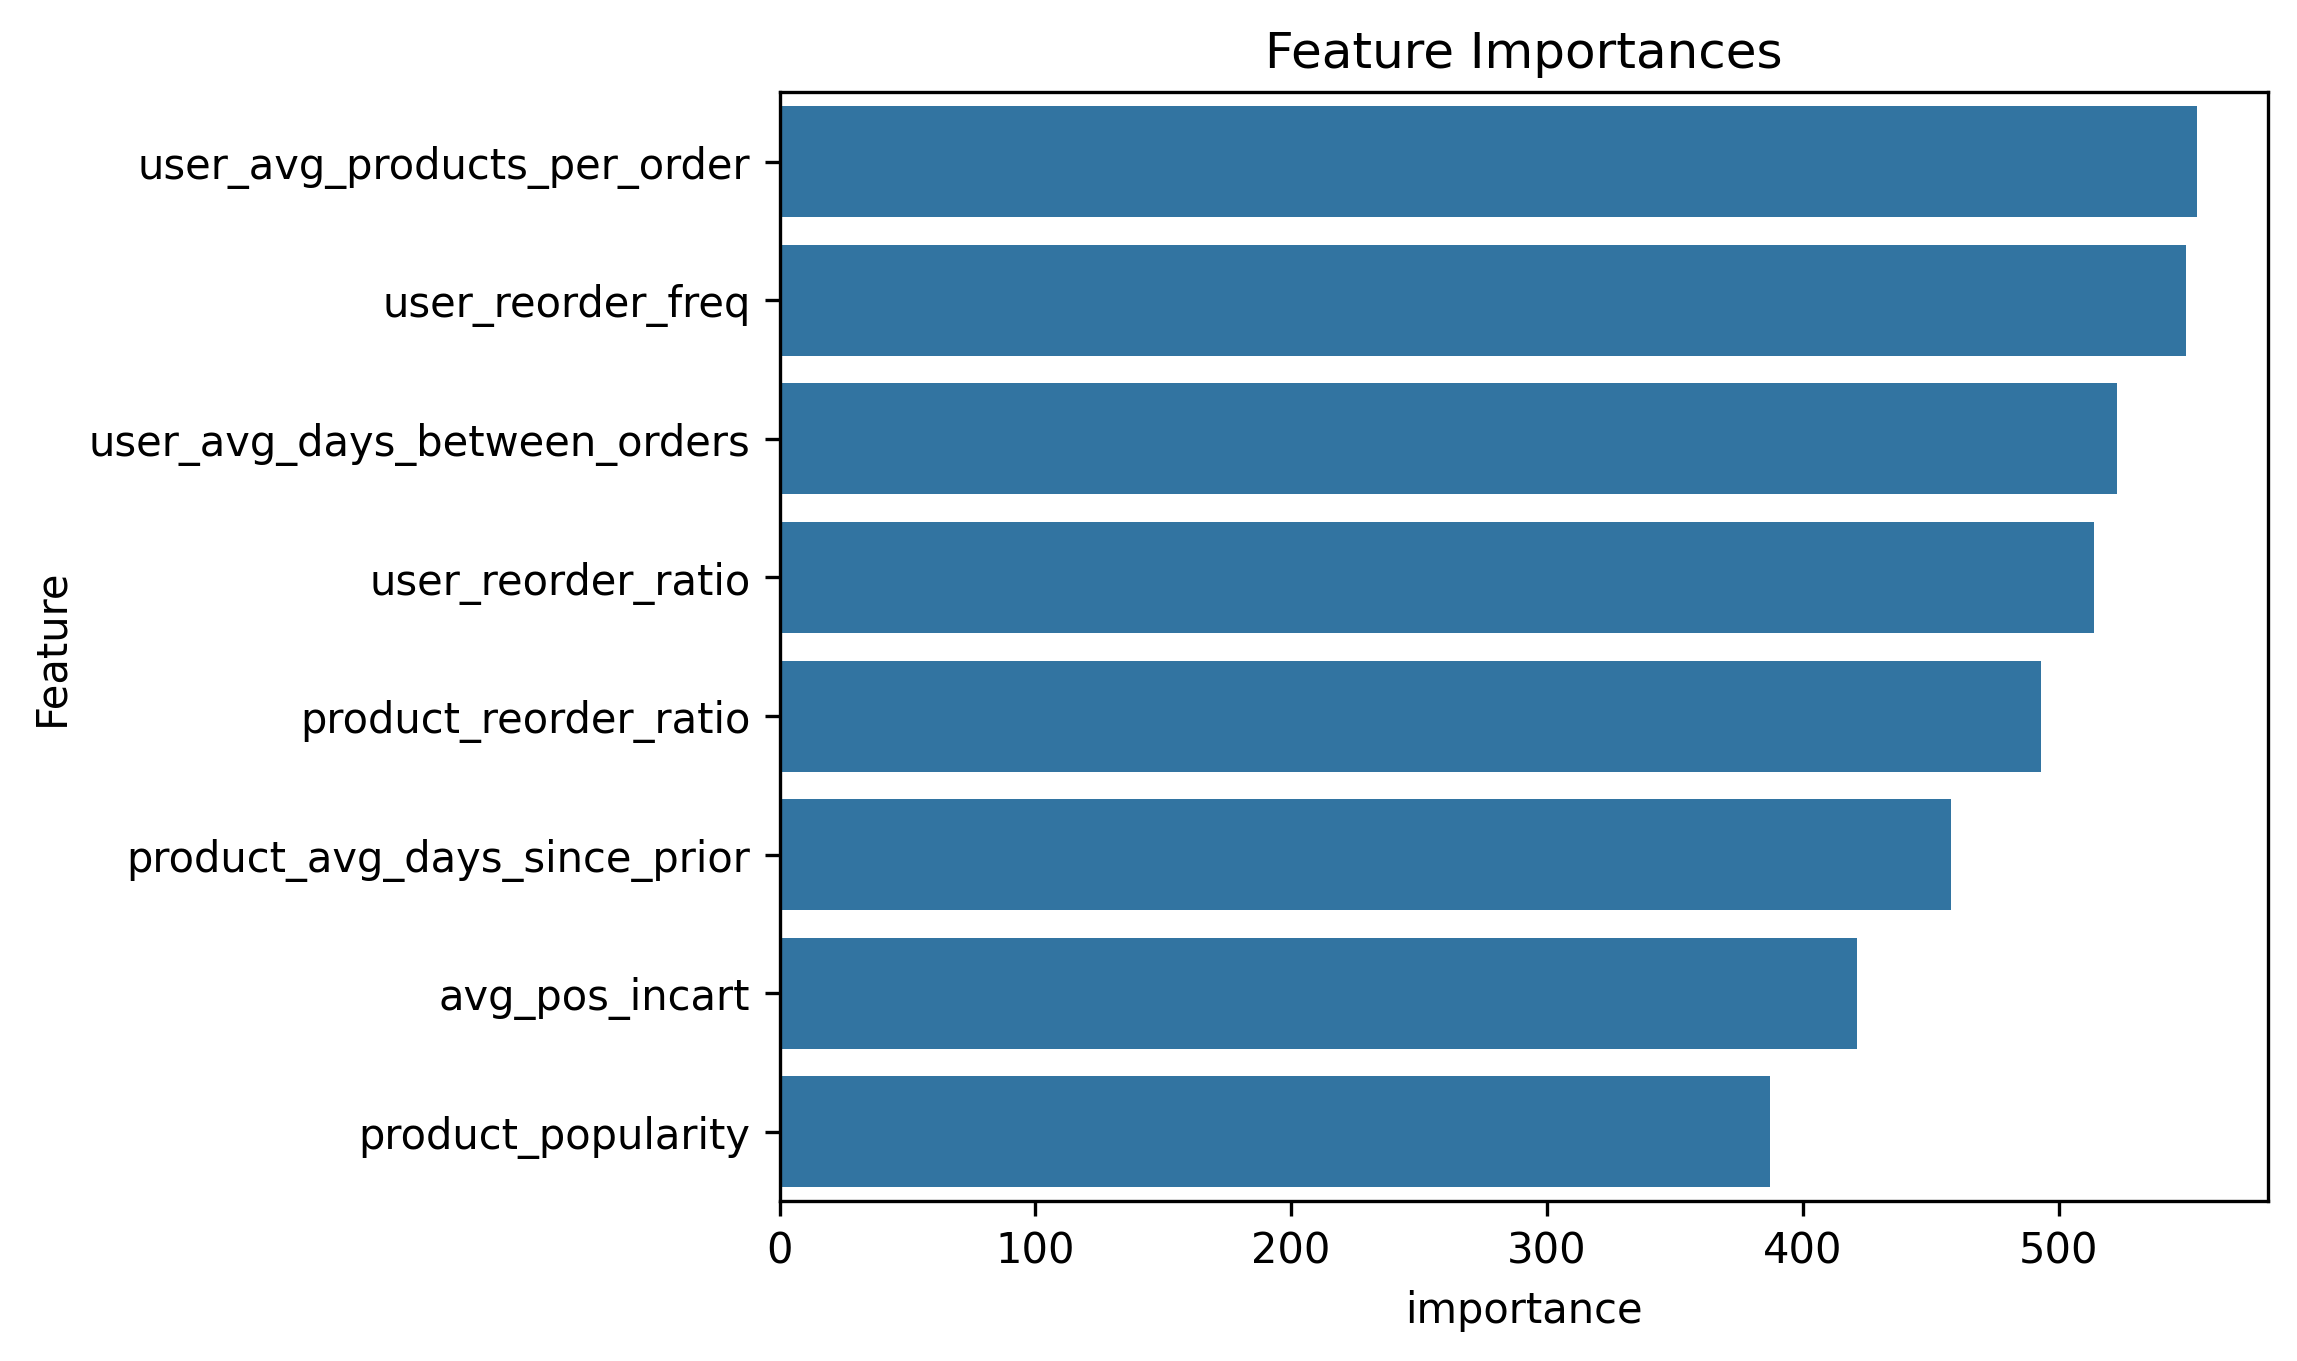

CPU times: user 21min 12s, sys: 2.68 s, total: 21min 15s
Wall time: 5min 55s


In [77]:
%%time
# Optuna hyperparameter optimization
model_.preprocess()
model_.full_optuna(k_folds=5)
model_.run()

In [78]:
# Calcular a métrica do Kaggle
results_df = pd.DataFrame({
    'user_id': model_.data[model_.data['is_test'] == 1]['user_id'].values,
    'y_true': model_.y_test.values,
    'y_pred': model_.predict(model_.X_test[model_.features])
})

# Calculando métrica kaggle
f1_kaggle = instacart_f1_score(results_df, 'user_id', 'y_true', 'y_pred')
print(f"F1 Score Kaggle: {f1_kaggle:.4f}")

F1 Score Kaggle: 0.7009


## Salvando resultados

In [101]:
# Definir o caminho onde os arquivos serão salvos
save_path = '/content/drive/MyDrive/case_rentcars/models'

# Salvar o modelo, métricas e gráficos
model_.save_model('modelo_treinado.pkl', path=save_path)
train_metrics, test_metrics = model_.evaluate()
model_.save_metrics('metricas_desempenho.json', train_metrics, test_metrics, path=save_path)
model_.save_feature_importances('importancia_das_features.csv', path=save_path)
model_.save_features(filename='selected_features.txt', path=save_path)
#model_.save_plots(path=save_path)

Modelo salvo como /content/drive/MyDrive/case_rentcars/models/modelo_treinado.pkl
Training Metrics:
AUC: 0.7739, KS: 0.4027, Log Loss: 0.5533, Accuracy: 0.7122, Precision: 0.7334, Recall: 0.8154, F1 Score: 0.7722
Testing Metrics:
AUC: 0.7668, KS: 0.3924, Log Loss: 0.5597, Accuracy: 0.7076, Precision: 0.7302, Recall: 0.8120, F1 Score: 0.7689
Métricas salvas como /content/drive/MyDrive/case_rentcars/models/metricas_desempenho.json
Importância das features salva como /content/drive/MyDrive/case_rentcars/models/importancia_das_features.csv
Features salvas em /content/drive/MyDrive/case_rentcars/models/selected_features.txt
